In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfd
import pathlib

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "drive/MyDrive/FYP/dataset"

In [6]:

DATA_DIR = pathlib.Path(data_dir)

image_count = len(list(DATA_DIR.glob('*/*.png')))
image_count

415

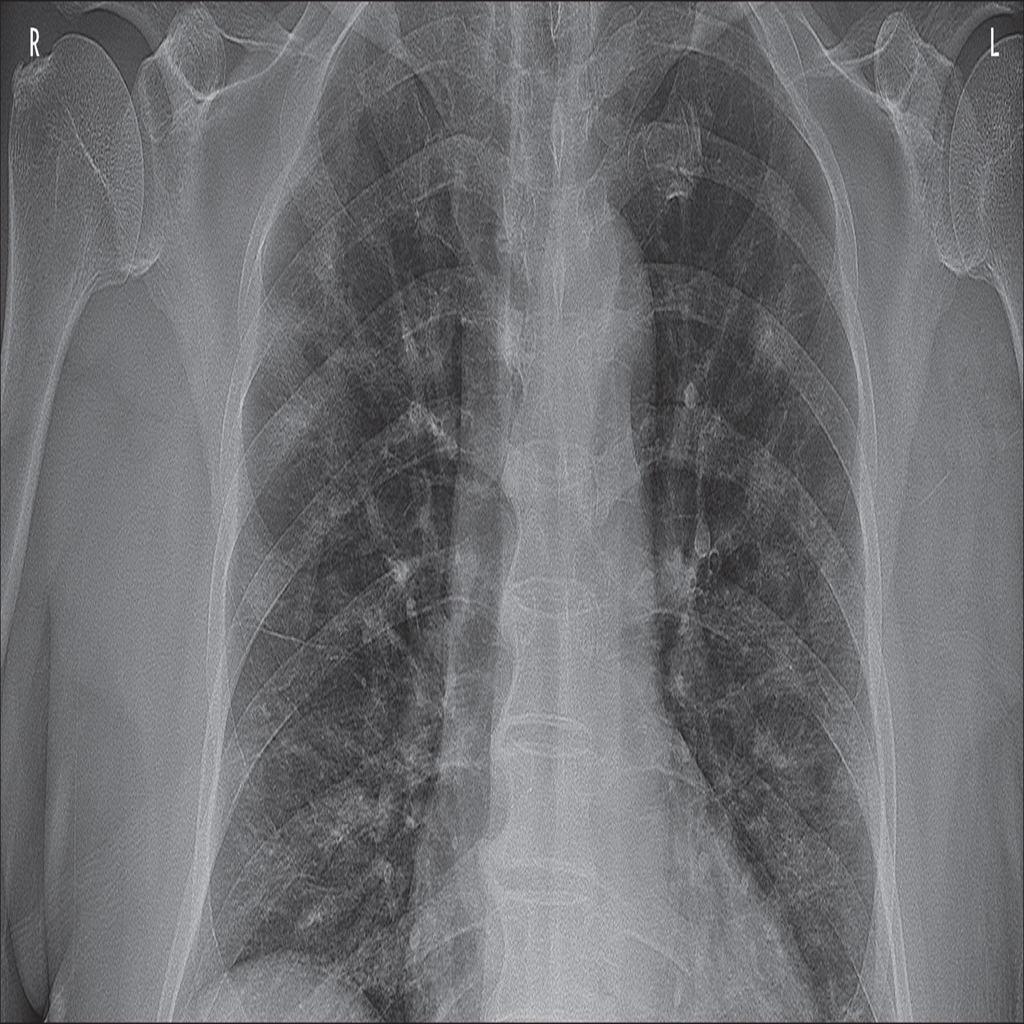

In [7]:
covid = list(DATA_DIR.glob('COVID-POSITIVE/*'))
PIL.Image.open(str(covid[0]))

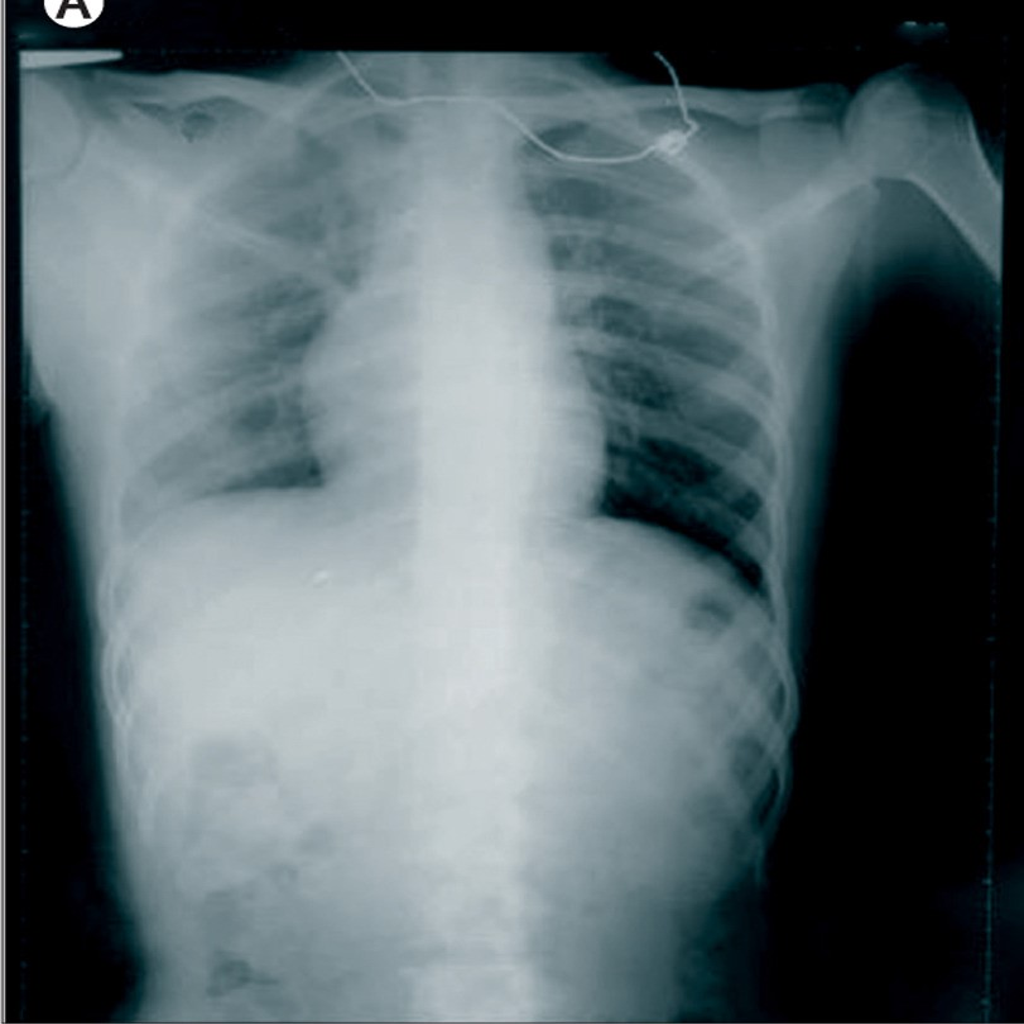

In [8]:
PIL.Image.open(str(covid[1]))

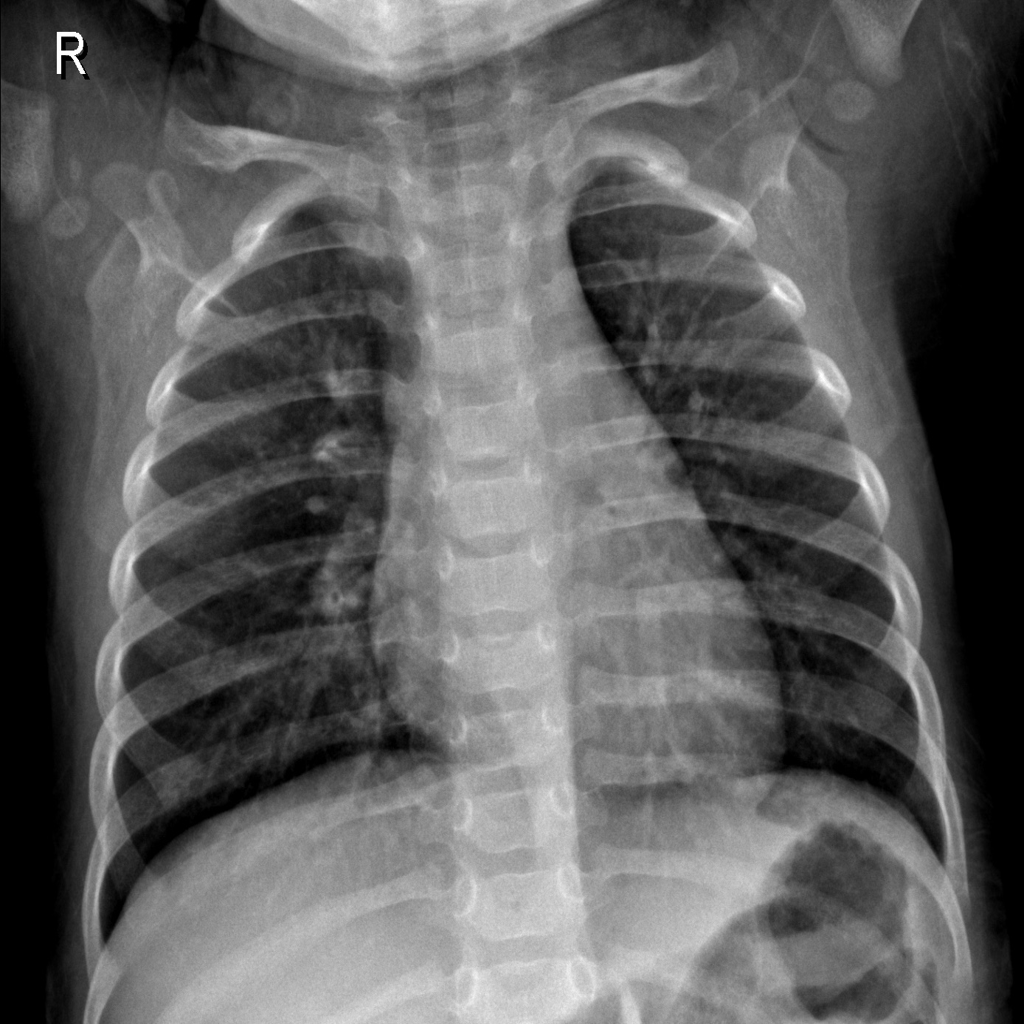

In [9]:
normal = list(DATA_DIR.glob('NORMAL/*'))
PIL.Image.open(str(normal[0]))

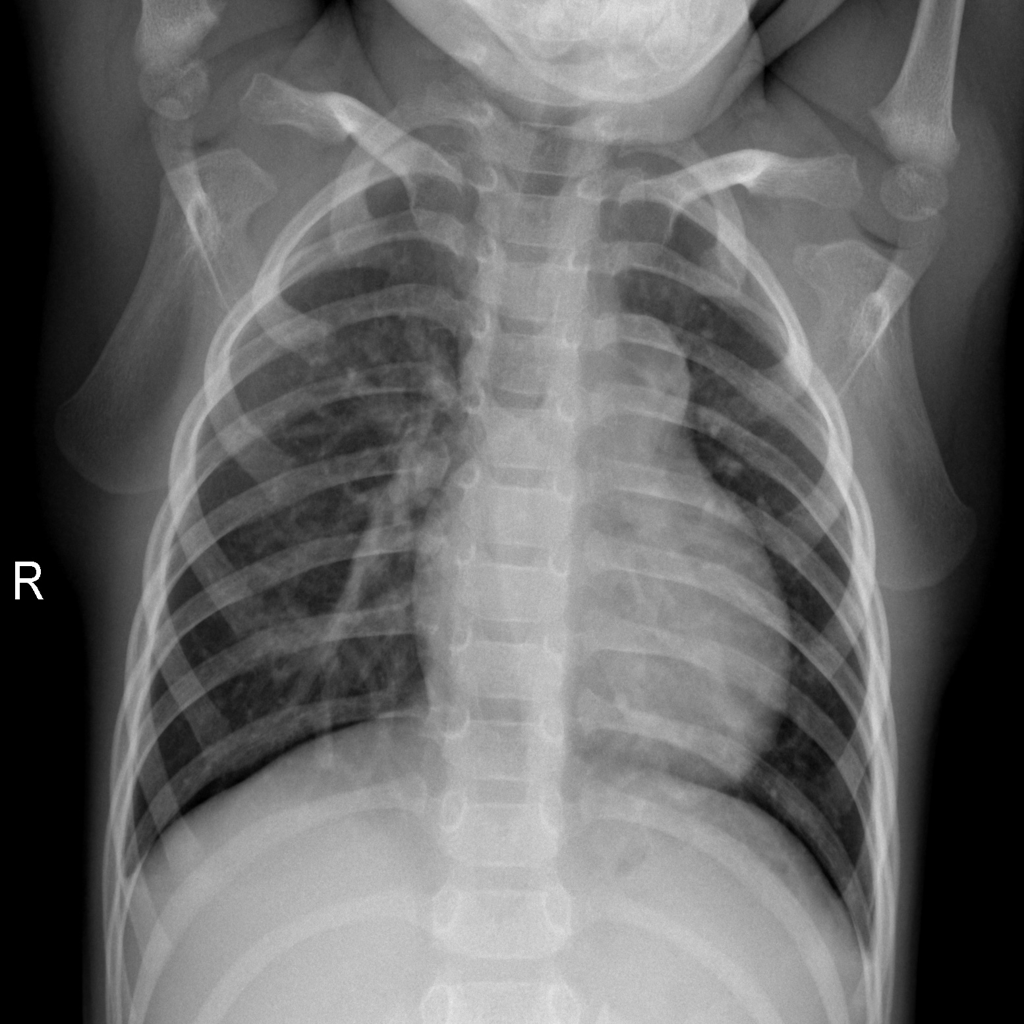

In [10]:
PIL.Image.open(str(normal[1]))

##### Preprocessing

In [12]:
batch_size = 10
img_height = 1024
img_width = 1024

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 415 files belonging to 2 classes.
Using 332 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 415 files belonging to 2 classes.
Using 83 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['COVID-POSITIVE', 'NORMAL']


### Visualizing Data

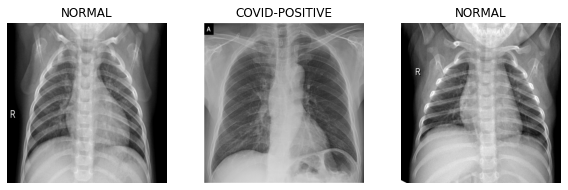

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(10, 1024, 1024, 3)
(10,)


**Configuring Dataset for performance**

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# val_ds.cache() This will ensure the dataset does not become a bottleneck while training your model
# .prefetch() overlaps data preprocessing and model execution while training.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the data**

In [21]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [23]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 1024, 1024, 3)     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1024, 1024, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0

In [26]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
34/34 [==============================] - 333s 10s/step - loss: 5.9236 - accuracy: 0.6627 - val_loss: 0.1323 - val_accuracy: 0.9398
Epoch 2/10
34/34 [==============================] - 292s 9s/step - loss: 0.2103 - accuracy: 0.9127 - val_loss: 0.2802 - val_accuracy: 0.8795
Epoch 3/10
34/34 [==============================] - 289s 9s/step - loss: 0.1025 - accuracy: 0.9669 - val_loss: 0.0811 - val_accuracy: 0.9639
Epoch 4/10
34/34 [==============================] - 289s 9s/step - loss: 0.0394 - accuracy: 0.9910 - val_loss: 0.1776 - val_accuracy: 0.9277
Epoch 5/10
34/34 [==============================] - 291s 9s/step - loss: 0.0240 - accuracy: 0.9940 - val_loss: 0.1223 - val_accuracy: 0.9518
Epoch 6/10
34/34 [==============================] - 290s 9s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0917 - val_accuracy: 0.9639
Epoch 7/10
34/34 [==============================] - 291s 9s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.9639
Epoch 8/10
3

**Visualizing results**

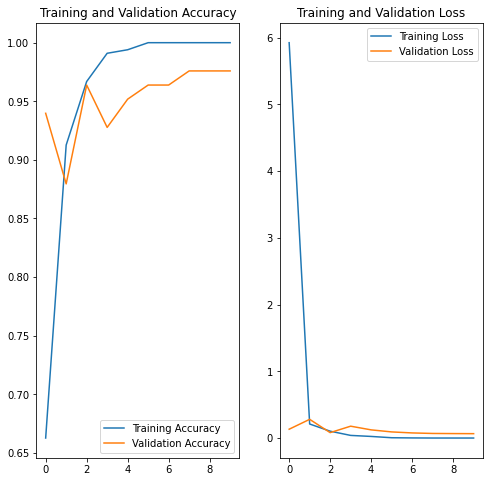

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Data Augmentation**

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

**Augmented data**

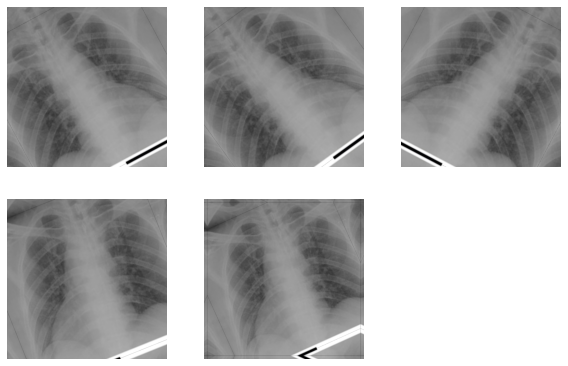

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(5):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1024, 1024, 3)     0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 1024, 1024, 3)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1024, 1024, 16)    448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 64)     

In [32]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
34/34 [==============================] - 381s 11s/step - loss: 11.4804 - accuracy: 0.6145 - val_loss: 0.3218 - val_accuracy: 0.9277
Epoch 2/15
34/34 [==============================] - 381s 11s/step - loss: 0.3779 - accuracy: 0.8343 - val_loss: 0.1985 - val_accuracy: 0.9277
Epoch 3/15
34/34 [==============================] - 383s 11s/step - loss: 0.2991 - accuracy: 0.8795 - val_loss: 0.1466 - val_accuracy: 0.9759
Epoch 4/15
34/34 [==============================] - 383s 11s/step - loss: 0.2907 - accuracy: 0.8946 - val_loss: 0.1814 - val_accuracy: 0.9277
Epoch 5/15
34/34 [==============================] - 382s 11s/step - loss: 0.2290 - accuracy: 0.9096 - val_loss: 0.0839 - val_accuracy: 0.9759
Epoch 6/15
34/34 [==============================] - 382s 11s/step - loss: 0.2492 - accuracy: 0.9006 - val_loss: 0.1837 - val_accuracy: 0.9518
Epoch 7/15
34/34 [==============================] - 394s 12s/step - loss: 0.4097 - accuracy: 0.8614 - val_loss: 0.2527 - val_accuracy: 0.9157
Epoch

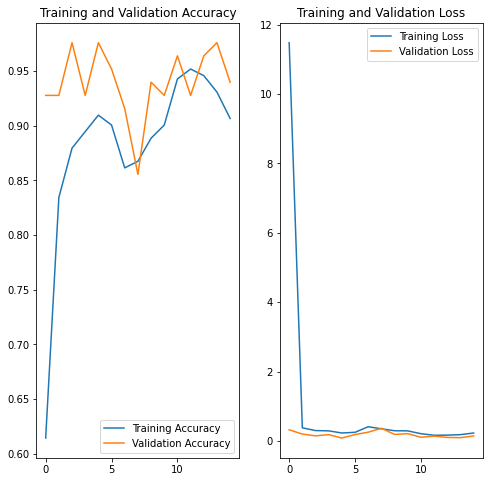

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
image_path = 'drive/MyDrive/FYP/n-Cov_pak dataset/img001.jpeg'

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to COVID-POSITIVE with a 98.57 percent confidence.


In [42]:
image_path1 = 'drive/MyDrive/FYP/n-Cov_pak dataset/img007.jpeg'


img = keras.preprocessing.image.load_img(
    image_path1, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to COVID-POSITIVE with a 100.00 percent confidence.


In [48]:
image_path2 = 'drive/MyDrive/FYP/n-Cov_pak dataset/IM-0022-0001.jpeg'


img = keras.preprocessing.image.load_img(
    image_path2, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NORMAL with a 88.41 percent confidence.


In [49]:
image_path3 = 'drive/MyDrive/FYP/IM-0001-0001.jpeg'


img = keras.preprocessing.image.load_img(
    image_path3, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NORMAL with a 65.74 percent confidence.


In [43]:
model.save("ncov_cls")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ncov_cls/assets
